#### Notebook for tuning, training, and testing a LightGBM based forecasting model for the BEICO park
We are forecasting (a quantile of) the minimum produced power in hourly intervals for 48-hours ahead. Data cleaning exploiting alarm information was performed by using all alarms . We make use of 0.1, 0.2, 0.3, 0.4, 0.5 quantiles.



#### Import Libraries


In [1]:
import sys
sys.path.insert(0,'/home/pgidarakos/Forecasting_Deliver/modules_deliv/')
from forecasting_modules import *
from matplotlib import pyplot as plt
from timeit import default_timer as timer
plt.style.use('ggplot')
import pandas as pd
from copy import deepcopy
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
import pickle 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from feature_engine.datetime import DatetimeFeatures
import warnings

/home/pgidarakos/.local/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/pgidarakos/.local/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/pgidarakos/.local/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


#### Load and apply filters
We load the data from the BEICO park that we have already resampled in hourly granularity and combined in one file. We also split the index of the data in train and testing for later usage.


In [2]:
df = pd.read_csv("/home/pgidarakos/Forecasting_30min/data1h.csv", index_col=0)

df.index = pd.to_datetime(df.index)

df = filter_dates(df, "2021-07-01", "2022-08-01")

train_index, test_index = df.loc[:"2022-07-01"].index, df.loc["2022-07-01":].index
df = df[[col for col in df.columns if 'Rtr' not in col]]

Clean some values of power by using a simple filter and IQR outlier detection method. The data manipulation is performed only on the training part of each turbine independantly.


In [3]:
df_outliers=df.copy()
for l in np.unique(df.label):
    l = int(l)
    df_label = df[df.label==l].copy()

 
    df_iqr = outliers_IQR(df_label.loc[df_label.index.isin(train_index)][['Grd_Prod_Pwr_avg', 'Amb_WindSpeed_avg']])
    df_label.loc[(~df_label.index.isin(df_iqr.index)) 
                 & (df_label.index.isin(train_index)),
                  ['Grd_Prod_Pwr_avg', 'Grd_Prod_Pwr_min',
                   'Grd_Prod_Pwr_max', 'Grd_Prod_Pwr_std']]=np.nan
    
    df_label['label'] = l
    ax = df_outliers.loc[df_outliers.label==l].plot.scatter(x='Amb_WindSpeed_avg', y='Grd_Prod_Pwr_avg')
    df_label.loc[df_label.index.isin(train_index)].plot.scatter(x='Amb_WindSpeed_avg', y='Grd_Prod_Pwr_avg', color='r', alpha=1, ax=ax, label='keep')
    plt.legend()
    df.loc[df.label==l]=df_label

We use sklearn's IterativeImputer to impute any the nan values in the dataset. IterativeImputer is fitted only on the training set.


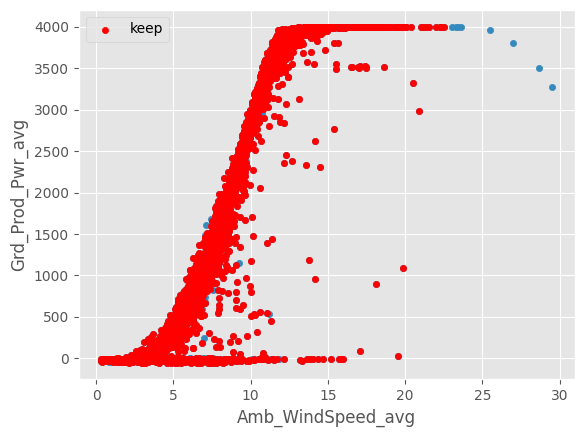

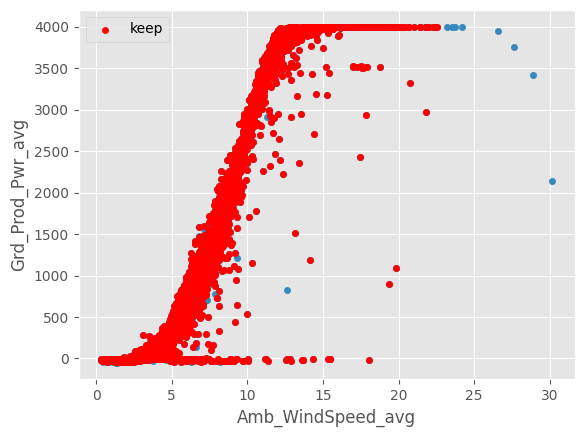

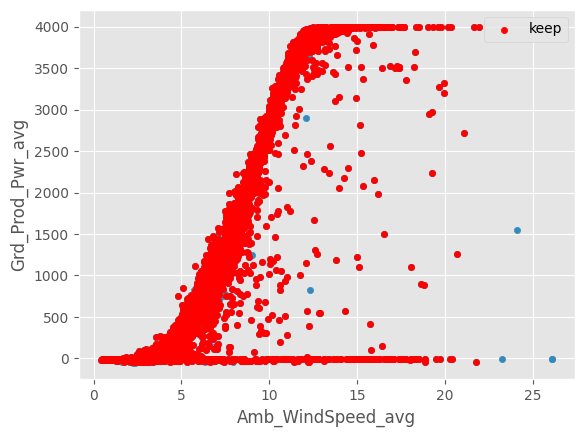

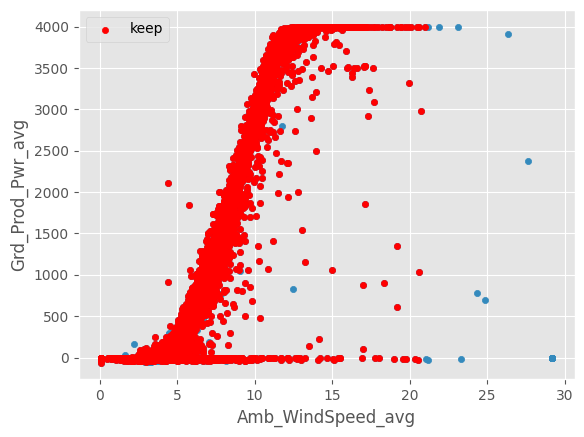

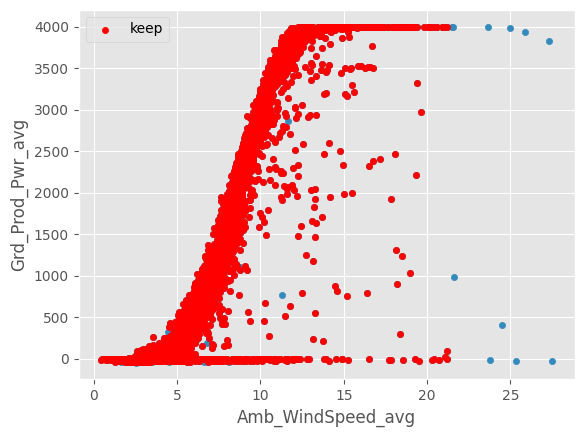

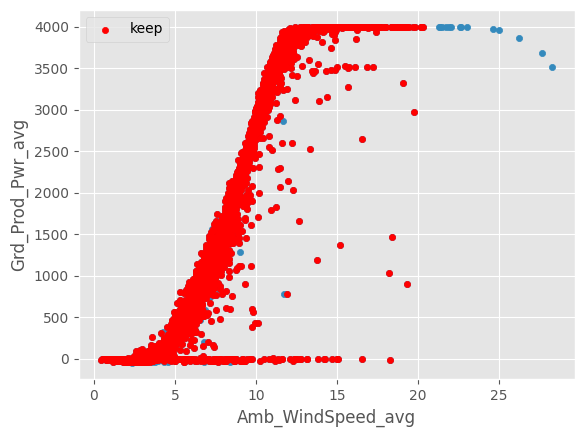

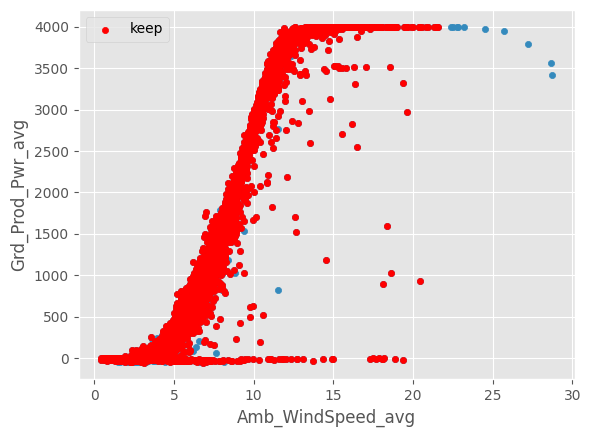

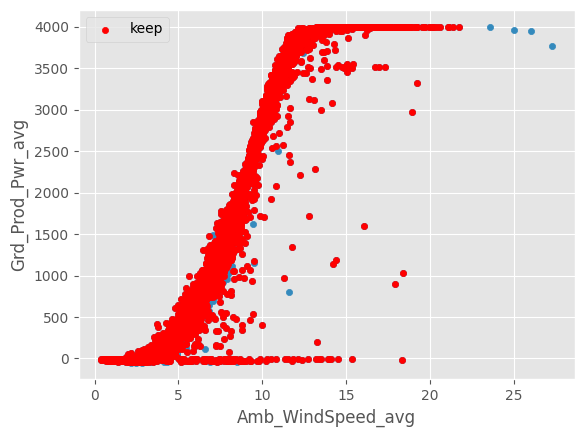

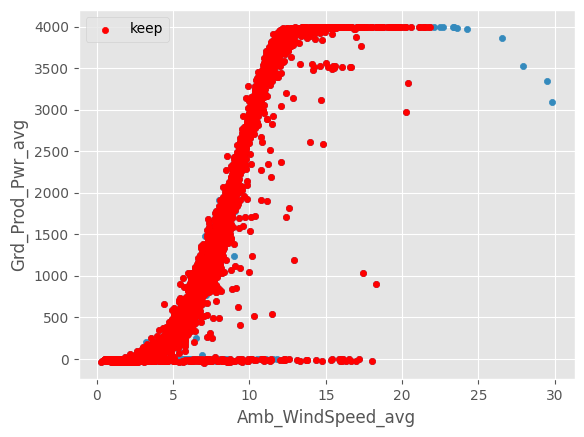

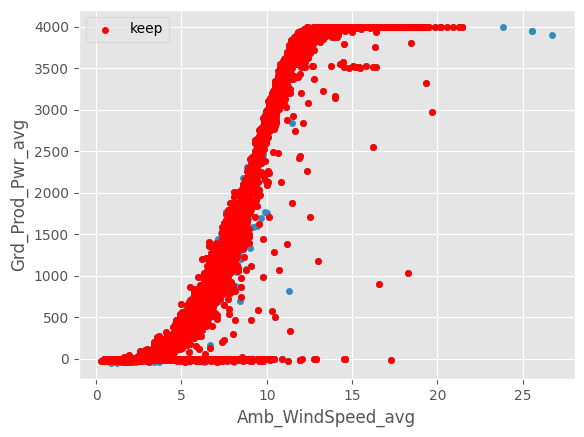

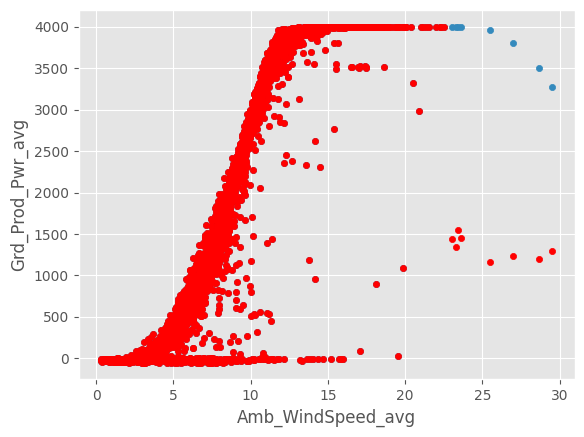

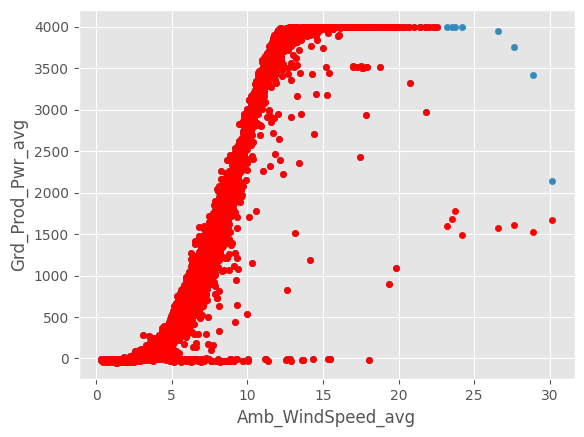

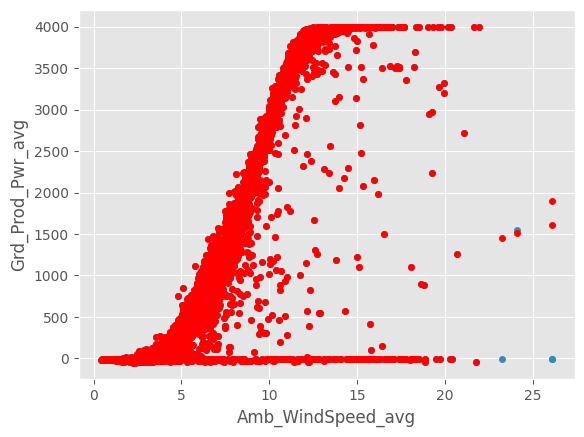

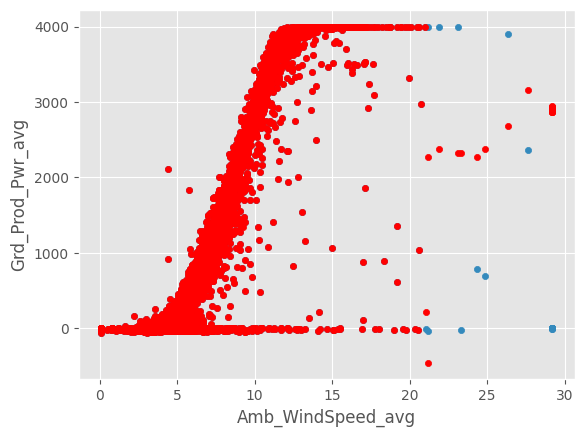

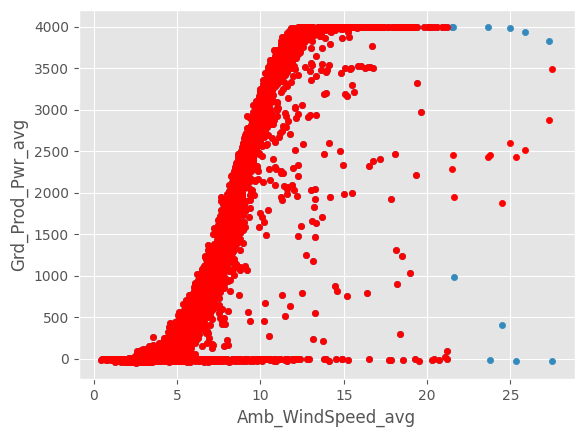

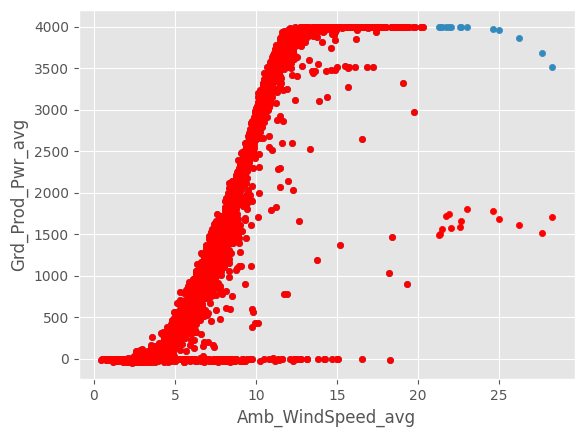

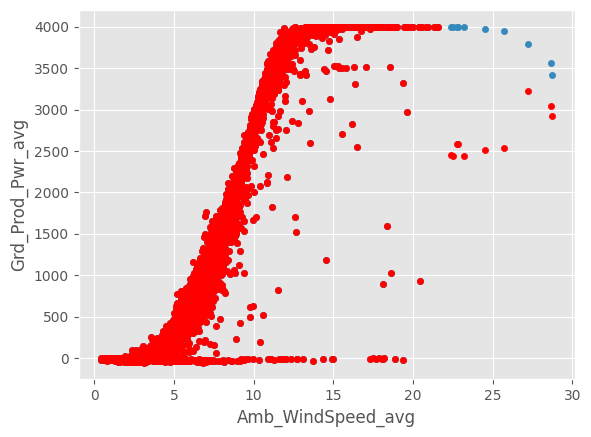

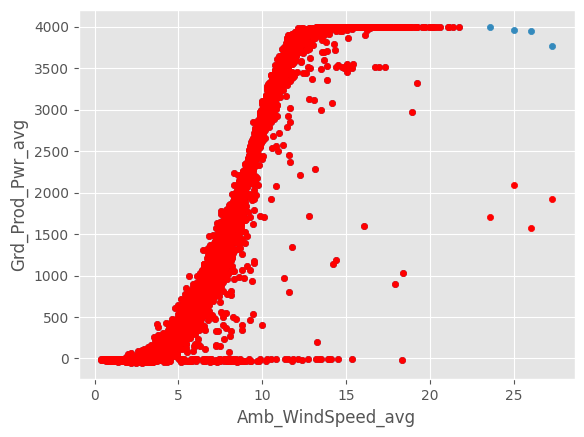

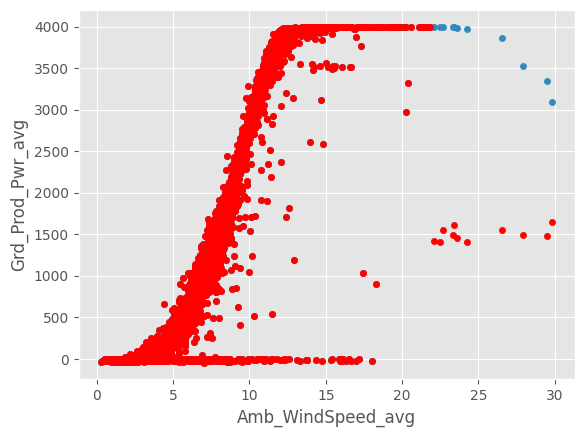

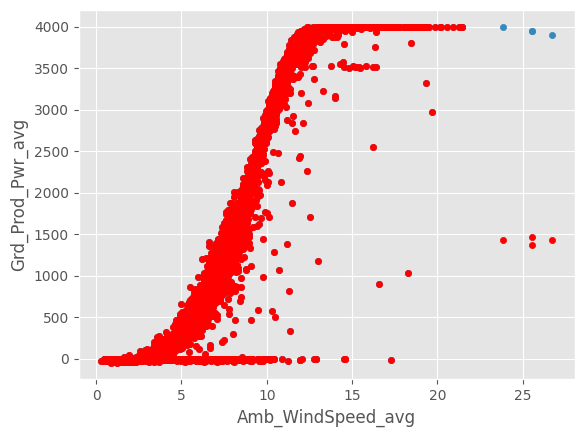

In [4]:
imp_mean = IterativeImputer(random_state=42, max_iter=50, skip_complete=True, tol=1, 
                            verbose=0, imputation_order='ascending', initial_strategy='mean',
                            n_nearest_features=None,)

for l in np.unique(df.label):
    l = int(l)
    df_label = df[df.label==l].copy()
    imp_mean.fit(df_label.loc[df_label.index.isin(train_index)].values)
    df_label = pd.DataFrame(imp_mean.transform(df_label.values), columns=df_label.columns, index=df_label.index)
    df_label.label = l
    df.loc[df.label==l]=df_label
    
for l in np.unique(df.label):
    l = int(l)
    ax = df_outliers[df_outliers.label==l].plot.scatter(x='Amb_WindSpeed_avg', y='Grd_Prod_Pwr_avg')
    df[df.label==l].plot.scatter(x='Amb_WindSpeed_avg', y='Grd_Prod_Pwr_avg', ax=ax, color='r')
    plt.show()
    
    



Add the future known values from ERA5, the targets and time based features for the future for in each feature vector

In [5]:
df_stops = pd.read_csv('/home/pgidarakos/Fore/forecasting_beico/Complete_models/stops/stops_per_turbine_with_all.csv', index_col=0, converters={'stop_times': pd.eval})
df_stops.index = df_stops.index.map(lambda x: int(x.replace('WT', "")))

df_list = []

for l in np.unique(df.label):
    df_temp = df[df.label==l].copy()
    stop_index = pd.Index(df_stops.loc[l, 'stop_times'])
    df_temp.loc[df_temp.index.isin(stop_index), 'Grd_Prod_Pwr_min'] = np.nan

    df_list.append(df_temp)
    
df = pd.concat(df_list, axis=0)

Here we create some lagged features and also some time based features.

In [6]:
lags = 3
df_list = []

for l in np.unique(df.label):

    df_lags_list = [df.loc[df.label==l]]
    df_temp = df.loc[df.label==l]
    for i in range(1, lags+1):
        df_temp = df_temp.shift(i)
        df_temp.columns = [c+f"_lag_{i}" for c in df_temp.columns]
        df_lags_list.append(df_temp.copy())
        
    df_lagged = pd.concat(df_lags_list, axis=1)
    
    dtfs = DatetimeFeatures(
        variables="index",
        features_to_extract=["month", "hour", "day_of_week"],
        drop_original=False
    )

    df_temp = dtfs.fit_transform(df_lagged.loc[df_lagged.label==l])
    df_list.append(df_temp.copy())

df = pd.concat(df_list, axis=0)

# df.info()

In [7]:
future_steps = 48
df_list = []
for l in np.unique(df.label):
    df_list_inner = [df.loc[df.label==l]]
    df_future = df.loc[df.label==l, ['Grd_Prod_Pwr_min', 'MeanWindSpeedUID_10.0m', 'MeanWindSpeedUID_100.0m', 
                                     'DirectionUID_10.0m', 'DirectionUID_100.0m', "month", "hour", "day_of_week"]]
    for i in range(1, future_steps+1):
        if i != 0:
            df_temp = df_future.shift(-i)
            df_temp.columns = [c+f"_(t+{i})" for c in df_future.columns]
            df_list_inner.append(df_temp) 

    df_f = pd.concat(df_list_inner, axis=1)
    df_f = df_f.dropna()
    df_f.head()
    df_list.append(df_f)

df_f = pd.concat(df_list, axis=0)

print(df_f.shape)

df_f = df_f.dropna()
print(df_f.shape)

(28260, 455)
(28260, 455)


Train/Test Split.


In [8]:
df_train, df_test = df_f.loc[df_f.index.isin(train_index)], df_f.loc[df_f.index.isin(test_index)]

target_features = [x for x in df_f.columns if 'Grd_Prod_Pwr_min_(t+' in x]
fit_features_test = [x for x in df_f.columns if 'Grd_Prod_Pwr_min_(t+' not in x]
fit_features = fit_features_test

We instantiate the regressor object and define possible parameters to try and then we perform the Time Series CV to find the optimal parameters for our model. Then we Train and Test the forecasting model using the parameters we found earlier for each quantile.


In [9]:
alpha=[['0.1'],['0.2'],['0.3'],['0.4'],['0.5']]
train_error=[]
test_error=[]
miss_error=[]
baseline_error=[]
for a in alpha:
    print("Fit with selected parameters and predict on test set for quantile",a[0])


    regression_models = {}

    lgbmr = LGBMRegressor(n_jobs=-1, deterministic=True,verbosity=-1)
    model = RegressorChain(lgbmr)
    parameters = {'regression__base_estimator__learning_rate': list(np.linspace(0.01, 0.3, 10)),
                  'regression__base_estimator__extra_trees': [True, False],
                  'regression__base_estimator__reg_alpha': [10**x for x in range(-6, 3, 1)],
                  'regression__base_estimator__reg_lambda': [10**x for x in range(-6, 3, 1)],
                  'regression__base_estimator__max_bin': [31, 63, 127, 255],
                  'regression__base_estimator__min_child_samples': [5, 10, 20],
                  'regression__base_estimator__num_leaves': [7, 15, 31],
                  'regression__base_estimator__subsample': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                  'regression__base_estimator__subsample_freq': [1, 5, 10, 20],
                  'regression__base_estimator__colsample_bytree': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                  'regression__base_estimator__n_estimators': list(range(100, 1000, 100)),
                  'regression__base_estimator__max_depth': list(range(1, 11, 2)),
                 'regression__base_estimator__objective': ['quantile'],  
                  'regression__base_estimator__alpha': a}

    pipeline = Pipeline([("regression", model)])
    regression_models['lgbm_regression'] = (pipeline, parameters)

#     hyper_params = {}
#     times = {}
#     for key, (pipeline, params) in regression_models.items():
#         print(f"Tuning and validating {key}...")
#         print(params.keys())
#         print(pipeline)
#         start = timer()
#         temp = perform_grid_search(df_train, fit_features_test, target_features, scorer, pipeline, params, randomized=True, cv=ts_cv, n_jobs=2, n_iter=150)
#         end = timer()
#         times[key] = end-start
#         print(f'Selected hyper-parameters for {key} \n {temp}')
#         hyper_params[key] = temp
#     print(times)
#     with open(f'/home/pgidarakos/Forecasting_Deliver/hyper_quant_{a}_all_alarms.pkl', 'wb') as f:
#         pickle.dump(hyper_params, f)
    hyper_params_reg = {}
    with open(f'/home/pgidarakos/Forecasting_Deliver/hyper_params/hyper_quant_{a}_all_alarms.pkl', 'rb') as handle:
        hyper_params_reg = pickle.load(handle)

    df_test1=df_test
    
    mapes = {}
    
    for key, (pipeline, _) in regression_models.items():
        chosen_params = hyper_params_reg[key]
        history = df_train
        train_mapes = []
        temp_pipeline1 = deepcopy(pipeline)
        quantile_params = deepcopy(chosen_params)
        pipeline_lower, y_pred, _, _, _, mape_train, _ = fit_pipeline(history, fit_features, target_features, temp_pipeline1, quantile_params)
#         print(pipeline==pipeline_lower)
        print(f"Training Mape {np.round(mape_train,4)}")

    
    p_list_pred=[]
    p_list=[]
    all_mapes=[]
    for l in np.unique(df.label):
        try:
            unq_idx = test_index.drop_duplicates()
            temp = np.empty((unq_idx.shape[0], future_steps))
            temp[:] = 1e-1
            result_container = pd.DataFrame(temp.copy(), index=unq_idx)
            y_pred_test =pipeline_lower.predict(df_test1.loc[df_test1.label==l][fit_features].values)
            result_temp = pd.DataFrame(y_pred_test, index=df_test1.loc[df_test1.label==l].index)
            result_container.loc[result_temp.index] = result_temp
            gt_container = pd.DataFrame(temp.copy(), index=unq_idx)
            y_test = df_test.loc[df_test.label==l][target_features]
            gt_temp = pd.DataFrame(y_test, index=df_test.loc[df_test.label==l].index)
            gt_container.loc[gt_temp.index] = gt_temp
            p_list_pred.append(result_container.copy())
            p_list.append(gt_container.copy())
            all_mapes.append(mape1(y_test, y_pred_test))
            

        except:
            continue
    park_mat_pred_lower = np.dstack(p_list_pred)
    park_mat = np.dstack(p_list)
    avg_test_preds = np.sum(park_mat_pred_lower, axis=2)
    avg_test = np.sum(park_mat, axis=2)
    print(f'Mape on park level {np.round(mape1(avg_test.ravel(), avg_test_preds.ravel()),4)}')
    p_baseline_pred = []
    for l in np.unique(df.label):
        try:
            unq_idx = test_index.drop_duplicates()
            temp = np.empty((unq_idx.shape[0], future_steps))
            temp[:] = 0
            baseline_container = pd.DataFrame(temp.copy(), index=unq_idx)
            p_baseline = naive_baseline(df_test[df_test.label==l])
            baseline_temp = pd.DataFrame(p_baseline, index=df_test.loc[df_test.label==l].index)
            baseline_container.loc[baseline_temp.index] = baseline_temp
            p_baseline_pred.append(baseline_container)
        except:
            continue
            

    park_mat_base_pred = np.dstack(p_baseline_pred)
    avg_base_preds = np.sum(park_mat_base_pred, axis=2)

        
   
    pom = np.round(percentage_of_misses(avg_test.ravel(), avg_test_preds.ravel()),4)
    print(f"Percentage of missses {pom}")
    train_error.append(mape_train)
    test_error.append(mape1(avg_test.ravel(), avg_test_preds.ravel()))
    miss_error.append(pom)
    baseline_error.append(mape1(avg_test.ravel(), avg_base_preds.ravel()))
    print()

Fit with selected parameters and predict on test set for quantile 0.1
Training Mape 0.8286
Mape on park level 1.0582
Percentage of missses 0.0226

Fit with selected parameters and predict on test set for quantile 0.2
Training Mape 0.6323
Mape on park level 0.8401
Percentage of missses 0.0516

Fit with selected parameters and predict on test set for quantile 0.3
Training Mape 0.4866
Mape on park level 0.7143
Percentage of missses 0.0721

Fit with selected parameters and predict on test set for quantile 0.4
Training Mape 0.1986
Mape on park level 0.3796
Percentage of missses 0.1825

Fit with selected parameters and predict on test set for quantile 0.5
Training Mape 0.1643
Mape on park level 0.3465
Percentage of missses 0.2203



Compare the training, test , and misses errors against each quantile.


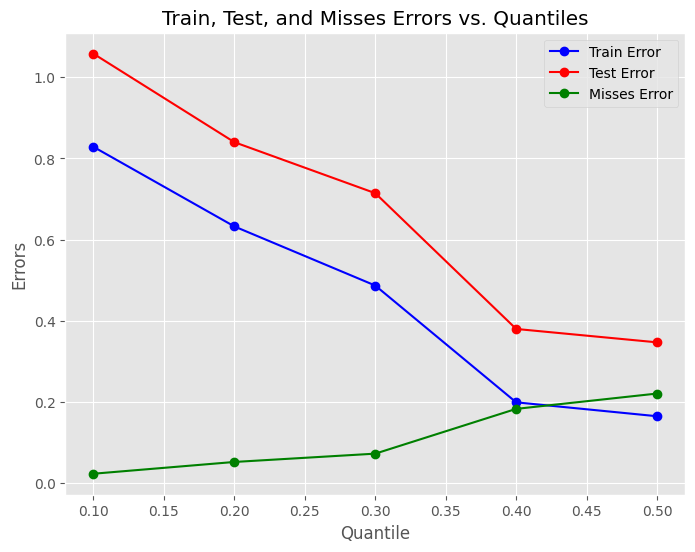

In [10]:
alpha=[0.1,0.2,0.3,0.4,0.5]
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.plot(alpha, train_error, marker='o', linestyle='-', color='blue', label='Train Error')
plt.plot(alpha, test_error, marker='o', linestyle='-', color='red', label='Test Error')
plt.plot(alpha, miss_error, marker='o', linestyle='-', color='green', label='Misses Error')
plt.xlabel('Quantile')
plt.ylabel('Errors')
plt.title('Train, Test, and Misses Errors vs. Quantiles')
plt.legend()
plt.show()